In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mgimg
import scipy as sp
import numpy as np
import cPickle as pickle
from scipy import interpolate
from scipy.interpolate import interp1d
from IPython.display import display
%matplotlib inline
#%config InlineBackend.close_figures = False
from scipy.io.idl import readsav
from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian1DKernel
#from pysynphot import observation
#from pysynphot import spectrum
import forwardmodel
import ciamod

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
array = pickle.load(open("test_H2H2_H2He_CIA_H2O.pic", "rb")) 
leveltemp = array[0]
levelpress = array[1]
mikespec = np.array([array[2],array[3]],dtype='f')
mikespec[0] = 10000.0 / mikespec[0]
print levelpress.size
print levelpress

80
[  9.99999975e-05   1.20226425e-04   1.44543999e-04   1.73780092e-04
   2.08929574e-04   2.51188700e-04   3.01995198e-04   3.63077997e-04
   4.36515693e-04   5.24807489e-04   6.30957249e-04   7.58577778e-04
   9.12010903e-04   1.09647808e-03   1.31825637e-03   1.58489251e-03
   1.90546061e-03   2.29086843e-03   2.75422912e-03   3.31131113e-03
   3.98107106e-03   4.78629908e-03   5.75439911e-03   6.91830833e-03
   8.31763912e-03   9.99999978e-03   1.20226424e-02   1.44543927e-02
   1.73780080e-02   2.08929572e-02   2.51188558e-02   3.01995184e-02
   3.63078006e-02   4.36515696e-02   5.24807498e-02   6.30957261e-02
   7.58577362e-02   9.12010893e-02   1.09647810e-01   1.31825641e-01
   1.58489242e-01   1.90546066e-01   2.29086712e-01   2.75422752e-01
   3.31131101e-01   3.98107082e-01   4.78629917e-01   5.75439930e-01
   6.91830814e-01   8.31763446e-01   1.00000000e+00   1.20226419e+00
   1.44543922e+00   1.73779988e+00   2.08929467e+00   2.51188707e+00
   3.01995182e+00   3.63077998e

In [3]:
# set up coarse pressure grid and fine pressure grid
logcoarsePress = np.arange(-4.0, 2.5, 0.53)
coarsePress = pow(10,logcoarsePress)
logfinePress = np.arange(-4.0, 2.4, 0.08)
finePress = pow(10,logfinePress)
print finePress.size
print coarsePress.size
print coarsePress
print finePress

80
13
[  1.00000000e-04   3.38844156e-04   1.14815362e-03   3.89045145e-03
   1.31825674e-02   4.46683592e-02   1.51356125e-01   5.12861384e-01
   1.73780083e+00   5.88843655e+00   1.99526231e+01   6.76082975e+01
   2.29086765e+02]
[  1.00000000e-04   1.20226443e-04   1.44543977e-04   1.73780083e-04
   2.08929613e-04   2.51188643e-04   3.01995172e-04   3.63078055e-04
   4.36515832e-04   5.24807460e-04   6.30957344e-04   7.58577575e-04
   9.12010839e-04   1.09647820e-03   1.31825674e-03   1.58489319e-03
   1.90546072e-03   2.29086765e-03   2.75422870e-03   3.31131121e-03
   3.98107171e-03   4.78630092e-03   5.75439937e-03   6.91830971e-03
   8.31763771e-03   1.00000000e-02   1.20226443e-02   1.44543977e-02
   1.73780083e-02   2.08929613e-02   2.51188643e-02   3.01995172e-02
   3.63078055e-02   4.36515832e-02   5.24807460e-02   6.30957344e-02
   7.58577575e-02   9.12010839e-02   1.09647820e-01   1.31825674e-01
   1.58489319e-01   1.90546072e-01   2.29086765e-01   2.75422870e-01
   3.3113

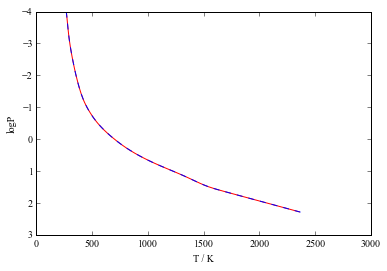

In [4]:
mikepress = np.empty(levelpress.size - 1,dtype='float64')
miketemp = np.empty(leveltemp.size -1, dtype='float64')
for i in range(0,mikepress.size):
    mikepress[i] = np.sqrt(levelpress[i] * levelpress[i+1])
mtfit = sp.interpolate.splrep(np.log10(levelpress),(leveltemp),s=10)
miketemp = sp.interpolate.splev(np.log10(mikepress),mtfit,der=0)
tfit = sp.interpolate.splrep(np.log10(mikepress),(miketemp),s=10)
temp = (np.asfortranarray(sp.interpolate.splev(np.log10(finePress),tfit,der=0),dtype='d'))

plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0.,3000.,3.0,-4.0])
plt.plot(miketemp,np.log10(mikepress),'r-')
plt.plot(temp,np.log10(finePress),'b--')
plt.ylabel(r'logP')
plt.xlabel('T / K')

#

In [5]:
# Get the linelists
ngas = 5
gasnum = np.asfortranarray(np.array([1,2,20,4,5],dtype='i'))
lists = ["../Linelists/xsecarrH2O_1wno_500_10000.save","../Linelists/xsecarrCH4_1wno_500_10000.save","../Linelists/xsecarrK_new_1wno_500_10000_02.save","../Linelists/xsecarrCO_1wno_500_10000_02.save","../Linelists/xsecarrCO2_1wno_500_10000_02.save" ]

In [6]:
x=readsav('../Linelists/xsecarrH2O_1wno_500_10000.save')
inlinelist=x.xsecarr  #3D array with Nwavenubmers x Ntemps x Npressure
inlinetemps=np.asfortranarray(x.t,dtype='float64')
inpress=x.p
inwavenum=x.wno
ntemps = inlinetemps.size
npress= finePress.size
nwave = inwavenum.size
#logpress = np.arange(-5.,2.5,0.125)
#press = 10.**logpress
#print press
print inpress[inpress.size-1]
# Here we are interpolating the linelist onto our fine pressure scale. 
linelist = (np.ones([ngas,npress,ntemps,nwave],order='F')).astype('float64', order='F')
for gas in range (0,ngas):
    inlinelist=readsav(lists[gas]).xsecarr
    for i in range (0,ntemps):
        for j in range (0,nwave):
            pfit = interp1d(np.log10(inpress),np.log10(inlinelist[:,i,j]))
            linelist[gas,:,i,j] = np.asfortranarray(pfit(np.log10(finePress)))
#print linelist.shape
#print np.result_type(linelist)
press = finePress*1000.

300.0


In [19]:
#intemp = np.loadtxt("16temps.dat",dtype='float32')
#intemp = np.full(16,1000.,dtype='f')
#inlayer = np.arange(0,15.25,1)  
#layer = np.arange(0,15.00,0.25)
#print layer.size
#tfit = interpolate.splrep(inlayer,intemp,s=0)
#temp = np.asfortranarray(interpolate.splev(layer,tfit, der=0),dtype='float32')
w1 = 1.0
w2 = 20.0
logg = 5.0
R2D2 = 1.0
#print inpress
#print mikepress
linelist[np.isnan(linelist)] = -50.0

In [20]:
VMR1 = np.full((npress,),(-3.5)) # water
vmr2 = np.full((npress,),(-3.4)) # ch4
vmr3 = np.full((npress,),(-8.0))  # K
vmr4 = np.full((npress,),(-7.5)) # CO
vmr5 = np.full((npress,),(-8.2)) # CO2
#print VMR1.shape
logVMR = np.asfortranarray(np.reshape((VMR1,vmr2,vmr3,vmr4,vmr5),(ngas,npress)),dtype='float64')
print logVMR.shape

(5, 80)


In [21]:
pcover = 1.0
do_clouds = 0
use_disort = 0
cloudnum = np.array([1],dtype='i')
#cloudname = np.reshape((cname),(1,1))
cloudrad = np.full((1,npress,1),1e-4)
cloudsig = np.full((1,npress,1),1e-5)
cloudprof = np.full((1,npress,1),0.0)

In [22]:
cia, ciatemps = ciamod.read_cia("CIA_DS_aug_2015.dat",inwavenum)
cia = np.asfortranarray(cia, dtype='float32')
ciatemps = np.asfortranarray(ciatemps, dtype='float32')
print cia.shape
print ciatemps.shape
print cia.dtype

(4, 198, 9501)
(198,)
float32


In [23]:
outspec = forwardmodel.marv(w1,w2,temp,logg,R2D2,gasnum,logVMR,pcover,do_clouds,cloudnum,cloudrad,cloudsig,cloudprof,inlinetemps,press,inwavenum,linelist,cia,ciatemps,use_disort)

In [24]:
#np.savetxt("disort16stream_test.dat",np.c_[outspec[0,:],outspec[1,:]])

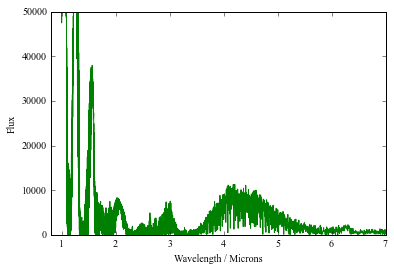

In [25]:
B = np.empty(nwave,dtype='d') 
B = 3.14159274*((2.*6.62606957e-34*(2.99792458e8**2.)) / ((outspec[0,:]*1.e-6)**5.)) / ((np.exp((6.62606957e-34*2.99792458e8)/(outspec[0,:]*1e-6*1.3806488e-23*1000.)))-1.) * 1.e-6
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0.8, 7.0,0.0,5e4])
#plt.plot(outspec[0,:],(outspec[1,:] / B),'r-')
#plt.plot(outspec[0,:],B,'b-')
plt.plot(outspec[0,:],outspec[1,:],'g-')
#plt.plot(mikespec[0,:],outspec[1,:] / (mikespec[1,:]/1e6),'r-')
#plt.plot(mikespec[0,:],((mikespec[1,:] / 1e6) / outspec[1,:]), 'r-')
#plt.plot(outspec[0,:],np.full(nwave,1.0),'b--')

#plt.plot(outspec[0,:],6.666*outspec[1,:],'b-')
plt.ylabel(r'Flux')
plt.xlabel('Wavelength / Microns')

#asp = 10 / 3.5

#plt.axes().set_aspect(asp)
plt.savefig('testspec.pdf',format='pdf', dpi=720)

In [26]:
wave = np.array(outspec[0,::-1])
flux = np.array(outspec[1,::-1])

# now calculate Fbol by summing the spectrum across its wave bins
fbol = 0.0
    
for j in range(1, (wave.size - 1)):
    sbin = ((wave[j] - wave[j-1]) + (wave[j+1] - wave[j])) / 2. 
    
    fbol = (sbin * flux[j]) + fbol

# now get T_eff
t_ff = ((fbol/(R2D2 * 5.670367e-8))**(1./4.))

In [27]:
print t_ff

905.608132571


In [28]:
print flux

[  5.30072341e+04   5.87866710e+04   5.98424257e+04 ...,   4.07578195e+01
   4.93585576e+01   5.31634420e+01]
